In [ ]:
import warnings
warnings.simplefilter("ignore")

## Import Pythonic libraries

In [2]:
import os
from json import loads as load_json
from json import dump as dump_json
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplhep as hep
import tensorflow as tf
import keras
import keras.backend as k
import keras.models
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from ROOT import TFile, TTree
import varsList

plt.style.use(hep.style.CMS)

Using TensorFlow backend.


Welcome to JupyROOT 6.20/06


### Define cut and weight variable values

In [3]:
leptonPt = 50.
isElectron = 1
isMuon = 1
corr_met = 60.
MT_lepMet = 60.
minDR_lepJet = 0.4
AK4HT = 510.
DataPastTriggerX = 1
MCPastTriggerX = 1
bJets = 2
nJets = 6

Choose a sample directory

In [4]:
dirList = next(os.walk(os.getcwd()))[1]
sampleDir = widgets.Dropdown( options = dirList )
sampleDir

Dropdown(options=('.git', '.sys.v#.Correlation Consideration.ipynb', '.sys.v#.Correlation Pandas.ipynb', '.sys…

Choose the signal sample

In [44]:
sigSample = widgets.Dropdown( options = os.listdir( sampleDir.value ) )
sigSample

Dropdown(options=('TTTT_TuneCP5_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8_tt1…

Choose the background sample

In [45]:
bkgSamples = widgets.SelectMultiple( options = os.listdir( sampleDir.value ) )
bkgSamples

SelectMultiple(options=('TTTT_TuneCP5_13TeV-amcatnlo-pythia8_hadd.root', 'TTTo2L2Nu_TuneCP5_13TeV-powheg-pythi…

Extract events from ROOT files

In [46]:
sigFile = TFile.Open( sampleDir.value + "/" + sigSample.value )
bkgFiles = {}
for file in bkgSamples.value:
    bkgFiles[file] = TFile.Open( sampleDir.value + "/" + file )

In [47]:
sigTree = sigFile.Get( "ljmet" )
bkgTrees = {}
for file in bkgSamples.value:
    bkgTrees[file] = bkgFiles[file].Get( "ljmet" )

Choose the directory containing the trained model and training reuslts.  Extract variables from `.json` file

In [48]:
dirList = next(os.walk(os.getcwd()))[1]
datasetDir = widgets.Dropdown( options = dirList )
datasetDir

Dropdown(options=('.git', '.sys.v#.Correlation Consideration.ipynb', '.sys.v#.Correlation Pandas.ipynb', '.sys…

In [49]:
jsonName = datasetDir.value + "/data.json"
jsonFile = open(jsonName)
jsonFile = load_json(jsonFile.read())

In [50]:
varListSub = jsonFile[list(jsonFile.keys())[0]]["parameters"]["variables"]

### Apply event selection

In [51]:
cutVars = [
    varListSub[0],varListSub[1],
    "leptonPt_MultiLepCalc","isElectron","isMuon","corr_met_MultiLepCalc","MT_lepMet",
    "minDR_lepJet","AK4HT","DataPastTriggerX","MCPastTriggerX","NJetsCSVwithSF_MultiLepCalc",
    "NJets_JetSubCalc","triggerXSF","pileupWeight","lepIdSF","EGammaGsfSF","isoSF",
    "L1NonPrefiringProb_CommonCalc","xsecEff","MCWeight_MultiLepCalc"
]

In [52]:
sigCut = np.asarray(
    sigTree.AsMatrix( cutVars )
)

bkgCut = {}

for file in bkgSamples.value:
    bkgCut[file] = np.asarray(
        bkgTrees[file].AsMatrix( cutVars )
    )

In [53]:
bkgCutComb = np.concatenate([bkgCut[file] for file in bkgSamples.value])

In [54]:
sigCutSort = sigCut[np.lexsort((sigCut[:,0],sigCut[:,1]))]
bkgCutSort = bkgCutComb[np.lexsort((bkgCutComb[:,0],bkgCutComb[:,1]))]

In [55]:
sigMask = np.zeros(np.shape(sigCutSort)[0])
bkgMask = np.zeros(np.shape(bkgCutSort)[0])
for i in range(np.shape(sigCutSort)[0]):
    if( ( sigCutSort[i,2] > leptonPt and sigCutSort[i,3] == isElectron ) or ( sigCutSort[i,2] > leptonPt and sigCutSort[i,4] == isMuon ) ):
        if( sigCutSort[i,5] > corr_met and sigCutSort[i,6] > MT_lepMet and sigCutSort[i,7] > minDR_lepJet and sigCutSort[i,8] > AK4HT ):
            if( sigCutSort[i,9] == DataPastTriggerX and sigCutSort[i,10] == MCPastTriggerX ):
                if( sigCutSort[i,11] >= bJets and sigCutSort[i,12] >= nJets ):
                    sigMask[i] = 1
for i in range(np.shape(bkgCutSort)[0]):
    if( ( bkgCutSort[i,2] > leptonPt and bkgCutSort[i,3] == isElectron ) or ( bkgCutSort[i,2] > leptonPt and bkgCutSort[i,4] == isMuon ) ):
        if( bkgCutSort[i,5] > corr_met and bkgCutSort[i,6] > MT_lepMet and bkgCutSort[i,7] > minDR_lepJet and bkgCutSort[i,8] > AK4HT ):
            if( bkgCutSort[i,9] == DataPastTriggerX and bkgCutSort[i,10] == MCPastTriggerX ):
                if( bkgCutSort[i,11] >= bJets and bkgCutSort[i,12] >= nJets ):
                    bkgMask[i] = 1

In [56]:
sigEvents = np.asarray(
    sigTree.AsMatrix( varListSub )
)

bkgEvents = {}

for file in bkgSamples.value:
    bkgEvents[file] = np.asarray(
        bkgTrees[file].AsMatrix( varListSub )
    )
    
bkgEventsComb = np.concatenate([bkgEvents[file] for file in bkgSamples.value])

In [57]:
sigEventsSort = sigEvents[np.lexsort((sigEvents[:,0],sigEvents[:,1]))]
bkgEventsSort = bkgEventsComb[np.lexsort((bkgEventsComb[:,0],bkgEventsComb[:,1]))]

Format data for testing with `Keras`

In [58]:
sigEventsCut = np.asarray(sigEventsSort)[sigMask.astype(bool)]
bkgEventsCut = np.asarray(bkgEventsSort)[bkgMask.astype(bool)]

In [59]:
sigLabels = np.full((np.shape(sigEventsCut)[0]),[1]).astype("bool")
bkgLabels = np.full((np.shape(bkgEventsCut)[0]),[0]).astype("bool")

In [60]:
y_all = np.concatenate((sigLabels,bkgLabels))
x_all = np.concatenate((sigEventsCut,bkgEventsCut))

In [61]:
x_train, x_test, y_train, y_test = train_test_split(
    x_all, y_all,
    test_size = 0.3
)

### Load in the trained optimized model

In [63]:
modelName = datasetDir.value + "/opt_model.h5"
model = keras.models.load_model(modelName)

In [64]:
all_predictions = model.predict(x_all)
sig_predictions = model.predict(sigEventsCut)
bkg_predictions = model.predict(bkgEventsCut)

Get the fake rate and efficiency as well as the Area under the Curve (AUC)

In [65]:
fpr, tpr, _ = roc_curve(y_all.astype(int), all_predictions[:,0])
AUC = auc(fpr,tpr)

# Plot the discriminator distributions

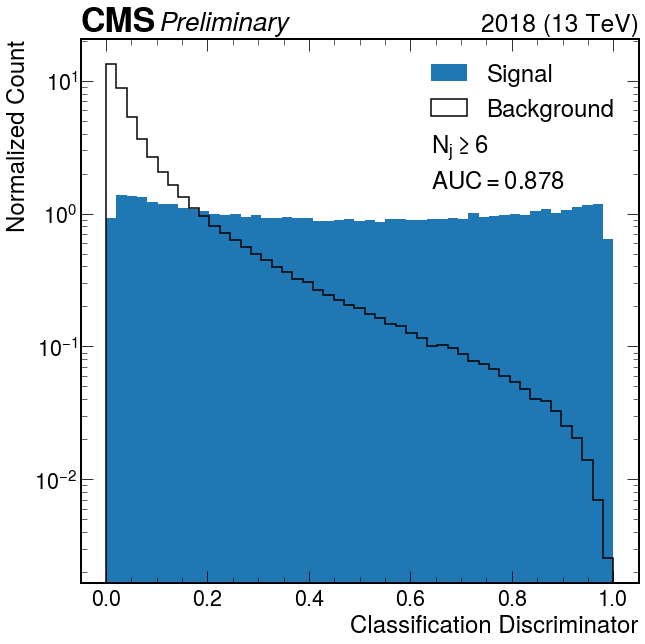

In [66]:
plt.style.use(hep.style.CMS)
plt.figure()
hep.cms.text("Preliminary")
hep.cms.lumitext("{} (13 TeV)".format(sampleDir.value.split("_")[1][4:]))
bins = np.linspace(0.,1.,50)
plt.hist(
    sig_predictions, bins = bins,
    label="Signal", density = True
)
plt.hist(
    bkg_predictions, bins = bins,
    label="Background", density = True,
    histtype = "step", color = "black", linewidth = 1.5
)

plt.annotate(
        r"$N_j\geq{}$".format(str(nJets)),
        xycoords = "axes pixels",
        xy = (350,430),
        fontsize = 24
)

plt.annotate(
        r"$AUC={:.3f}$".format(AUC),
        xycoords = "axes pixels",
        xy = (350,395),
        fontsize = 24
)

plt.ylabel("Normalized Count", y = 1.0, ha = "right", fontsize = 24)
plt.yscale("log")
plt.xlabel("Classification Discriminator", x = 1.0, ha = "right", fontsize = 24)
plt.legend(loc="best",fontsize=24)
plt.show()

# Plot the $k$-fold cross validation AUC

In [67]:
fpr = {}
tpr = {}

k_tot = len(jsonFile[list(jsonFile.keys())[0]]["fpr"])

for k in range(k_tot):
    fpr[k] = np.array([float(x) for x in jsonFile[list(jsonFile.keys())[0]]["fpr"][k].split(",")])
    tpr[k] = np.array([float(x) for x in jsonFile[list(jsonFile.keys())[0]]["tpr"][k].split(",")])

In [68]:
fpr_avg = []
tpr_avg = []
fpr_std = []
tpr_std = []

for i in range (20):
    fpr_avg.append(np.mean([fpr[k][i] for k in range(k_tot)]))
    tpr_avg.append(np.mean([tpr[k][i] for k in range(k_tot)]))
    fpr_std.append(np.std([fpr[k][i] for k in range(k_tot)]))
    tpr_std.append(np.std([tpr[k][i] for k in range(k_tot)]))

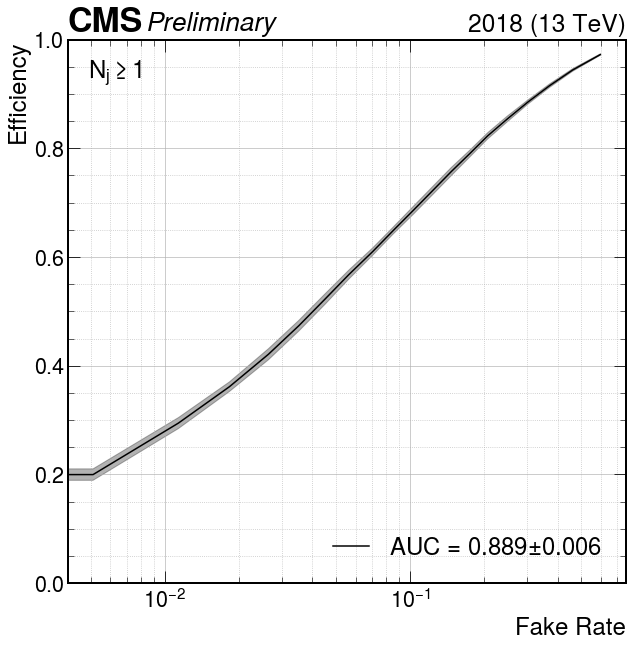

In [69]:
plt.figure()
hep.cms.text("Preliminary")
hep.cms.lumitext("{} (13 TeV)".format(sampleDir.value.split("_")[1][4:]))

plt.plot(
    fpr_avg,tpr_avg,
    label="AUC = {:.3f}$\pm${:.3f}".format(
        np.mean(jsonFile[list(jsonFile.keys())[0]]["roc_integral"]),
        np.std(jsonFile[list(jsonFile.keys())[0]]["roc_integral"])
        ),
    color = "k"
)
plt.fill_between(
    fpr_avg,
    np.array(tpr_avg)-np.array(tpr_std),
    np.array(tpr_avg)+np.array(tpr_std),
    alpha=0.3, color="k"
)

plt.annotate(
        r"$N_j\geq{}$".format(sampleDir.value.split("_")[1][0]),
        xycoords = "axes pixels",
        xy = (20,505),
        fontsize = 24
)
plt.xlabel("Fake Rate", x = 1.0, ha = "right", fontsize = 24)
plt.ylabel("Efficiency", y = 1.0, ha = "right",  fontsize = 24)
plt.ylim(0,1.0)
plt.xscale("log")
plt.grid(which="major",linestyle="-")
plt.grid(which="minor",linestyle=":")
plt.minorticks_on()
plt.legend(loc=4, fontsize = 24)
plt.show()